# Soil grading tutorial (Prototype)
# A code examples for SoilGrading component
This component simulates fragmentation of soil grains through time based on mARM (Cohen et al., 2009, 2010) approach.
The fragmentation process is controlled by a weathering transition matrix which defines the relative mass change in each soil grain size class (grading class) as a result of the fracturing of particles in the weathering mechanism.

## References:
Cohen, S., Willgoose, G., & Hancock, G. (2009). The mARM spatially distributed soil
    evolution model: A computationally efficient modeling framework and analysis of
    hillslope soil surface organization. Journal of Geophysical Research: Earth Surface,
    114(F3).

Cohen, S., Willgoose, G., & Hancock, G. (2010). The mARM3D spatially distributed
    soil evolution model: Three‐dimensional model framework and analysis of hillslope
    and landform responses. Journal of Geophysical Research: Earth Surface, 115(F4).

# First, 
load components.
On this branch, SoilGrading is not part of Landlab's components libary so we need to load it from its origin. 

In [374]:
# Load components
import numpy as np
import matplotlib.pyplot as plt
from funcs.soil_grading import SoilGrading
from landlab import RasterModelGrid

Lets create a simple grid with only 1 core node. The grid dimensions will be 3x3

In [375]:
# Create simple grid with only 1 core node
grid = RasterModelGrid((3, 3), xy_spacing=1)
core_node = grid.core_nodes

Init SoilGrading by an a-priori grain size distribution.

In [376]:
sg.output_var_names

('grains__weight',
 'grains_classes__size',
 'median_size__weight',
 'soil__depth')

Lets have a look on SoilGrading output vars

In [377]:
# Call SoilGrading with a-priori grain size distribution
meansizes = [0.01, 0.1, 1]        # grain sizes [m]
grains_weight = [10, 10, 10]      # grains weight [kg/m^2]

sg = SoilGrading(grid,
            meansizes=meansizes,
            grains_weight=grains_weight)

The median size at node is calculated by weight.
Lets verify that:

In [378]:
print('Weights [kg/m^2] of grains classes in node are', grid.at_node['grains__weight'][core_node])
print('The median size in node is',grid.at_node['median_size__weight'][core_node][0],'m')

Weights [kg/m^2] of grains classes in node are [[10. 10. 10.]]
The median size in node is 0.1 m


The main procedure of SoilGrading (run_one_step) will transfer mass between the grain size classes.
Mass transfer is based on transition matrix, by default, set to a 100% of mass transfer from parent to dauther(s). 
In this tutorial, we will assume that the smallest size class dosent break into smaller fragments.

In [379]:
sg.run_one_step()

Verify mass transfer and new median grain size:

In [380]:
print('Weights [kg/m^2] of grains classes in node are', grid.at_node['grains__weight'][core_node])
print('The median size in node is',grid.at_node['median_size__weight'][core_node][0],'m')

Weights [kg/m^2] of grains classes in node are [[20. 10.  0.]]
The median size in node is 0.01 m


In the case we dont have measurments or we are not intreseted in specific grain size distribution, we can ask SoilGrading to create one. In this case, we need to provide maximal grain size and fragmentation pattern. 


Let's test two options: grain size distributions with a reduction of 50% and 77% in mass between each subsequent class.
Accordingly, transfer of mass from a parent class to the next (smaller) class results in 2 and 3 daughters grains, respectively. 

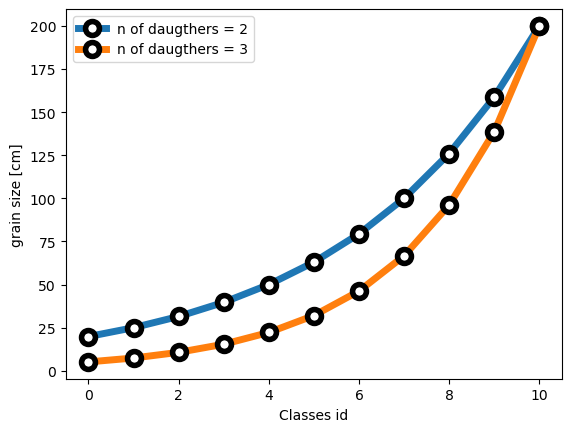

In [387]:
grading_name ='p2-0-100'
grain_max_size = 2
n_sizes=11
power_of= 1 / 3

precent_of_volume_in_spread=0
mean_sizes_2, limits, fragmentation_pattern = sg.create_grading(
        grading_name,
        grain_max_size,
        power_of=power_of,
        n_sizes=n_sizes,
        precent_of_volume_in_spread=0,
    )
plt.plot(limits[:,1]*100, label=f'n of daugthers = 2',markersize=20,markeredgecolor='black',lw=5,markerfacecolor='white',markeredgewidth=4,marker='.')

power_of= 1 / 3
grading_name ='p3-0-100'

precent_of_volume_in_spread=0
mean_sizes_3, limits, fragmentation_pattern = sg.create_grading(
        grading_name,
        grain_max_size,
        power_of=power_of,
        n_sizes=n_sizes,
        precent_of_volume_in_spread=0,
    )
plt.plot(limits[:,1]*100, label=f'n of daugthers = 3',markersize=20,markeredgecolor='black',lw=5,markerfacecolor='white',markeredgewidth=4,marker='.')
plt.xlabel('Classes id')
plt.ylabel('grain size [cm]')
plt.legend()
plt.show()

We will continue with the grain size distribution in which the mass reduction between subsequent classes is 50%. 
SoilGrading will use this grain size distribution as an input and will spread mass randomly around the median size.

In [382]:
grid = RasterModelGrid((3, 3), xy_spacing=1)
sg = SoilGrading(grid,
            meansizes=mean_sizes_2)
sizes_cm = grid.at_node['grains_classes__size'][grid.core_nodes[0]]*100

Text(0, 0.5, 'Fraction from total mass')

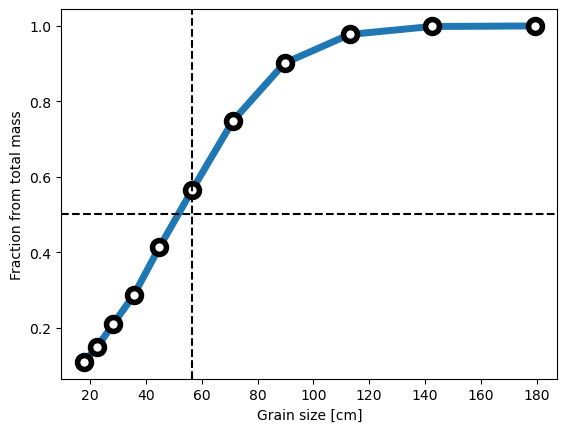

In [383]:
plt.plot(sizes_cm,
    np.cumsum(grid.at_node['grains__weight'][grid.core_nodes[0]])/np.sum(grid.at_node['grains__weight'][grid.core_nodes[0]]),
    marker='.',markersize=20,markeredgecolor='black',lw=5,markerfacecolor='white',markeredgewidth=4)
plt.axhline(y=0.5,ls='--',color='black')
plt.axvline(x=sizes_cm[5],ls='--',color='black')
plt.xlabel('Grain size [cm]')
plt.ylabel('Fraction from total mass')

A function for plotting

In [384]:
import matplotlib as mpl
c1='blue' #blue
c2='gray' #green
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In the last stage, we will simulate 1500 cycles of fragmentation (lets say each represent 1-year) assuming that in each cycle 0.1% of the mass in each size class is weathering. 
Remmember: in this tutorial we assume that the smallest grain size class dosent break into smaller fragments.

Text(0, 0.5, 'Fraction from total mass')

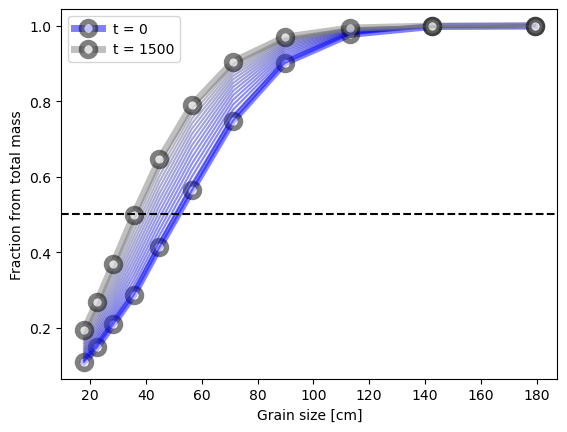

In [385]:
n=1500 # Lets say its years
plot_interval = 100
plot_cnt = 0
for i in range(n):
    sg.run_one_step(A_factor=0.001)
    
    
    if i==0:
        plt.plot(sizes_cm, np.cumsum(grid.at_node['grains__weight'][grid.core_nodes[0]])/np.sum(grid.at_node['grains__weight'][grid.core_nodes[0]]),
            marker='.',color=colorFader(c1,c2,i/n),alpha=0.5,label='t = 0',markeredgecolor='black',lw=5,markerfacecolor='white',markeredgewidth=4,markersize=20)
    elif i==n-1:
        plt.plot(sizes_cm, np.cumsum(grid.at_node['grains__weight'][grid.core_nodes[0]])/np.sum(grid.at_node['grains__weight'][grid.core_nodes[0]]),
            marker='.',color=colorFader(c1,c2,i/n),alpha=0.5,label=f't = {n}',markeredgecolor='black',lw=5,markerfacecolor='white',markeredgewidth=4,markersize=20)
    elif i>plot_cnt:
        plt.plot(sizes_cm, np.cumsum(grid.at_node['grains__weight'][grid.core_nodes[0]])/np.sum(grid.at_node['grains__weight'][grid.core_nodes[0]]),color=colorFader(c1,c2,i/n),alpha=0.5)
        plot_cnt+=plot_interval
plt.legend()
plt.axhline(y=0.5,ls='--',color='black')

plt.xlabel('Grain size [cm]')
plt.ylabel('Fraction from total mass')

We got some cool reduction in grain size with time!

In [386]:
p =2
N=3
power_of =1/3
d = p * (1 / N) ** (power_of)
(d**3)*3, p**3


(7.999999999999998, 8)